I pick a random red galaxy from the GAMA-Legacy overlap and simulate different velocity dispersions in order to see if there's a chance we can fit for velocity dispersion for BGS galaxies

In [1]:
import os 
import h5py 
import numpy as np 
import astropy.units as u 
# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import skymodel as Sky 
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM 
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]
/anaconda2/envs/gqp/lib/python3.7/site-packages/desispec-0.22.1-py3.7.egg/desispec/maskbits.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """)
/anaconda2/envs/gqp/lib/python3.7/site-packages/desitarget-0.22.0-py3.7.egg/desitarget/targetmask.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _bitdefs = yaml.load(fx)


In [2]:
cata = Cat.GamaLegacy()
gleg = cata.Read('g15', dr_gama=3, dr_legacy=7, silent=True)  

In [3]:
# extract meta-data of galaxies 
redshift        = gleg['gama-spec']['z']
absmag_ugriz    = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3, galext=False) # ABSMAG k-correct to z=0.1
r_mag_apflux    = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1]) # aperture flux
r_mag_gama      = gleg['gama-photo']['r_petro'] # r-band magnitude from GAMA (SDSS) photometry
ha_gama         = gleg['gama-spec']['ha_flux'] # halpha line flux

In [4]:
# match GAMA galaxies to templates 
bgs3 = FM.BGStree()
match = bgs3._GamaLegacy(gleg)
hasmatch = (match != -999)
criterion = hasmatch 

INFO:io.py:998:read_basis_templates: Reading /Users/ChangHoon/data/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits metadata.


In [5]:
# lets pick a bright galaxy at z~0.2 
np.random.seed(0)
igal = np.atleast_1d(np.random.choice(np.arange(len(redshift))[(r_mag_gama < 18.) & (redshift > 0.19) & (redshift < 0.2) & (absmag_ugriz[1,:] - absmag_ugriz[2,:] > 1.0)]))

In [6]:
print('redshift = %.2f' % redshift[igal])

redshift = 0.19


(-0.5, 1.5)

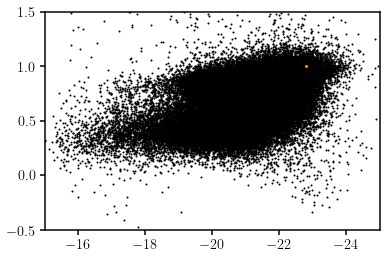

In [7]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(absmag_ugriz[2,:], absmag_ugriz[1,:] - absmag_ugriz[2,:], c='k', s=1)
sub.scatter(absmag_ugriz[2,igal], absmag_ugriz[1,igal] - absmag_ugriz[2,igal], c='C1', s=5)
sub.set_xlim(-15, -25)
sub.set_ylim(-0.5, 1.5)

In [8]:
# generate noiseless spectra for these galaxies 
s_bgs = FM.BGSsourceSpectra(wavemin=1500.0, wavemax=15000) 

vdisps = [50, 150, 400]
waves, fluxes = [], [] 
for vdisp in vdisps: 
    emline_flux = s_bgs.EmissionLineFlux(gleg, index=igal, dr_gama=3, silent=True) # emission lines from GAMA 

    flux, wave, _, magnorm_flag = s_bgs.Spectra(
        r_mag_apflux[igal], 
        redshift[igal],
        vdisp, 
        seed=1, 
        templateid=match[igal], 
        emflux=emline_flux, 
        mag_em=r_mag_gama[igal], 
        silent=True)
    waves.append(wave)
    fluxes.append(flux)


INFO:io.py:1010:read_basis_templates: Reading /Users/ChangHoon/data/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits


/anaconda2/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


Absorption Lines
3934.777	-1.0	0.0	K
3969.588	-1.0	0.0	H
4305.61	-1.0	0.0	G
5176.7	-1.0	0.0	Mg
5895.6	-1.0	0.0	Na
8500.36	-1.0	0.0	CaII
8544.44	-1.0	0.0	CaII
8664.52	-1.0	0.0	CaII

### SEDs with different velocity dispersions

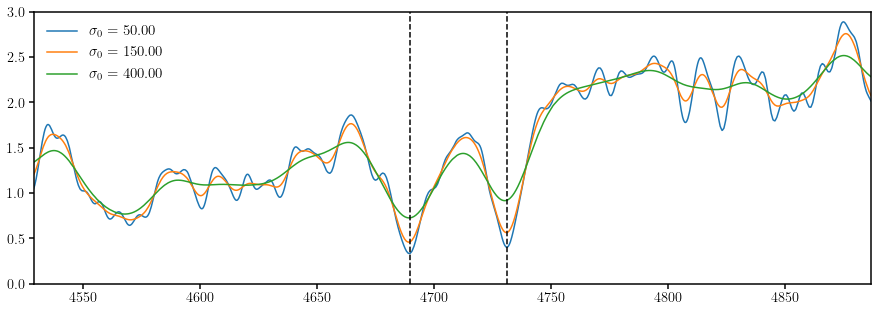

In [9]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for flux, vdisp in zip(fluxes, vdisps): 
    sub.plot(waves[0], flux[0], label=r'$\sigma_0 = %.2f$' % vdisp)
sub.plot([3934.777*(1.+redshift[igal]), 3934.777*(1.+redshift[igal])], [0., 10.], c='k', ls='--')
sub.plot([3969.588*(1.+redshift[igal]), 3969.588*(1.+redshift[igal])], [0., 10.], c='k', ls='--')

sub.set_xlim(3800*(1.+redshift[igal]),4100*(1.+redshift[igal]))
sub.set_ylim(0., 3)
sub.legend(loc='upper left', fontsize=15)

In [10]:
dir_dat = os.path.join(UT.dat_dir(), 'srp')
fexps       = h5py.File(os.path.join(dir_dat, 'exposures_surveysim_fork_150sv0p5.sample.seed0.hdf5'), 'r')
texp        = fexps['texp_total'][...]
airmass     = fexps['airmass'][...]
moon_ill    = fexps['moon_ill'][...]
moon_alt    = fexps['moon_alt'][...]
moon_sep    = fexps['moon_sep'][...]
sun_alt     = fexps['sun_alt'][...]
sun_sep     = fexps['sun_sep'][...]
seeing      = fexps['seeing'][...]
transp      = fexps['transp'][...]

n_sample    = len(airmass) 

# read in sky brightness 
wave_sky    = fexps['wave'][...]
u_sb        = 1e-17 * u.erg / u.angstrom / u.arcsec**2 / u.cm**2 / u.second
sky_sbright = fexps['sky'][...]

iexp = 0 
print('t_exp = %.f' % texp[iexp])

# iexp-th sky spectra 
Isky = [wave_sky, sky_sbright[iexp]]

# simulate the exposures 
fdesi = FM.fakeDESIspec()

bgses = []
for wave, flux in zip(waves, fluxes): 
    bgs = fdesi.simExposure(wave, flux, exptime=texp[iexp], airmass=airmass[iexp], Isky=Isky) 
    bgses.append(bgs)

t_exp = 540


/anaconda2/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/anaconda2/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/anaconda2/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In

### BGS spectra with realistic exposure

Text(0, 0.5, 'flux [$10^{-17} erg/s/cm^2/A$]')

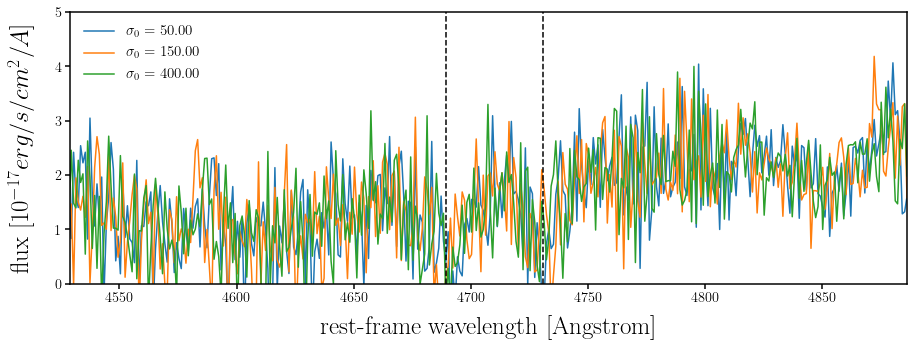

In [11]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111) 
for i, bgs, vdisp in zip(range(len(vdisps)), bgses, vdisps): 
    for band in ['b', 'r', 'z']: 
        lbl = None
        if band == 'b': lbl = (r'$\sigma_0=%.2f$' % vdisp)
        sub.plot(bgs.wave[band], bgs.flux[band][0], c='C%i' % i, label=lbl) 
sub.legend(loc='upper right', fontsize=20)
    
sub.plot([3934.777*(1.+redshift[igal]), 3934.777*(1.+redshift[igal])], [0., 10.], c='k', ls='--')
sub.plot([3969.588*(1.+redshift[igal]), 3969.588*(1.+redshift[igal])], [0., 10.], c='k', ls='--')

sub.set_xlim(3800*(1.+redshift[igal]),4100*(1.+redshift[igal]))
sub.set_ylim(0., 5)
sub.legend(loc='upper left', fontsize=15)

bkgd = fig.add_subplot(111, frameon=False) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bkgd.set_xlabel('rest-frame wavelength [Angstrom]', labelpad=10, fontsize=25) 
bkgd.set_ylabel('flux [$10^{-17} erg/s/cm^2/A$]', labelpad=10, fontsize=25) 

In [12]:
bgses = []
for wave, flux in zip(waves, fluxes): 
    bgs = fdesi.simExposure(wave, flux, exptime=2.*texp[iexp], airmass=airmass[iexp], Isky=Isky) 
    bgses.append(bgs)

/anaconda2/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/anaconda2/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/anaconda2/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In

### BGS spectra with optimistic exposure

Text(0, 0.5, 'flux [$10^{-17} erg/s/cm^2/A$]')

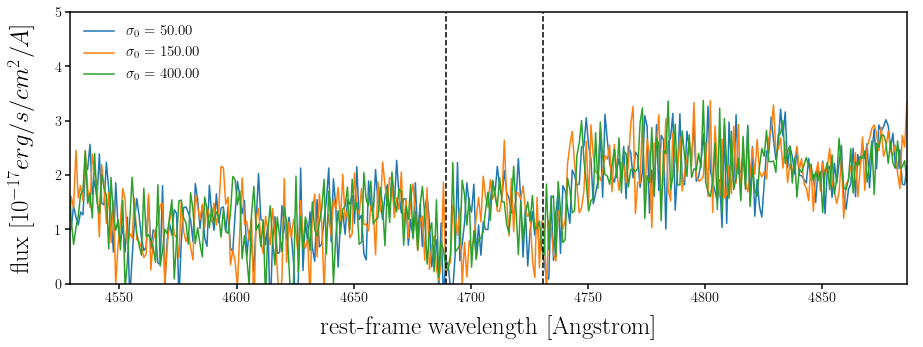

In [13]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111) 
for i, bgs, vdisp in zip(range(len(vdisps)), bgses, vdisps): 
    for band in ['b', 'r', 'z']: 
        lbl = None
        if band == 'b': lbl = (r'$\sigma_0=%.2f$' % vdisp)
        sub.plot(bgs.wave[band], bgs.flux[band][0], c='C%i' % i, label=lbl) 
sub.legend(loc='upper right', fontsize=20)
    
sub.plot([3934.777*(1.+redshift[igal]), 3934.777*(1.+redshift[igal])], [0., 10.], c='k', ls='--')
sub.plot([3969.588*(1.+redshift[igal]), 3969.588*(1.+redshift[igal])], [0., 10.], c='k', ls='--')

sub.set_xlim(3800*(1.+redshift[igal]),4100*(1.+redshift[igal]))
sub.set_ylim(0., 5)
sub.legend(loc='upper left', fontsize=15)

bkgd = fig.add_subplot(111, frameon=False) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bkgd.set_xlabel('rest-frame wavelength [Angstrom]', labelpad=10, fontsize=25) 
bkgd.set_ylabel('flux [$10^{-17} erg/s/cm^2/A$]', labelpad=10, fontsize=25) 

In [14]:
Isky = [wave_sky, np.zeros(len(wave_sky))]

bgses = []
for wave, flux in zip(waves, fluxes): 
    bgs = fdesi.simExposure(wave, flux, exptime=100.*texp[iexp], airmass=airmass[iexp], Isky=Isky) 
    bgses.append(bgs)

/anaconda2/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/anaconda2/envs/gqp/lib/python3.7/site-packages/specsim-0.14.dev804-py3.7.egg/specsim/transform.py:595: UserWarning: Refraction model is inaccurate for altitudes below 5.0 deg.
  .format(low_altitude_threshold))
/anaconda2/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_sli

### spectra without sky noise 
to check that we're not limited by the spectral resolution of DESI

Text(0, 0.5, 'flux [$10^{-17} erg/s/cm^2/A$]')

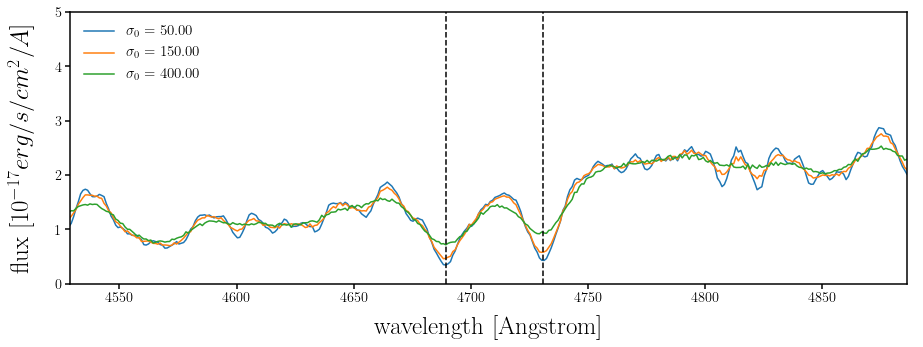

In [16]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111) 
for i, bgs, vdisp in zip(range(len(vdisps)), bgses, vdisps): 
    for band in ['b', 'r', 'z']: 
        lbl = None
        if band == 'b': lbl = (r'$\sigma_0=%.2f$' % vdisp)
        sub.plot(bgs.wave[band], bgs.flux[band][0], c='C%i' % i, label=lbl) 
sub.legend(loc='upper right', fontsize=20)
    
sub.plot([3934.777*(1.+redshift[igal]), 3934.777*(1.+redshift[igal])], [0., 10.], c='k', ls='--')
sub.plot([3969.588*(1.+redshift[igal]), 3969.588*(1.+redshift[igal])], [0., 10.], c='k', ls='--')

sub.set_xlim(3800*(1.+redshift[igal]),4100*(1.+redshift[igal]))
sub.set_ylim(0., 5)
sub.legend(loc='upper left', fontsize=15)

bkgd = fig.add_subplot(111, frameon=False) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bkgd.set_xlabel('wavelength [Angstrom]', labelpad=10, fontsize=25) 
bkgd.set_ylabel('flux [$10^{-17} erg/s/cm^2/A$]', labelpad=10, fontsize=25) 